In [1]:
# base
import requests
import datetime
import copy
import json
import time
import os

# finance
# import yfinance as yf
import apimoex as moex
import numpy as np
import pandas as pd
from typing import NamedTuple

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning models
# from sklearn.linear_model import LinearRegression, LogisticRegression
# from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import torch
from torch import nn
from torch import default_generator, randperm
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataset import Subset
from torch._utils import _accumulate

# metrics
## classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
## regression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# data manipulation
from sklearn.model_selection import train_test_split

SEED = 20240704

In [2]:
os.listdir()

['NeuralNetwork.ipynb',
 'news.csv',
 'origin_fake.csv',
 'rbc.txt',
 'rbc_once.ipynb',
 'rbc_once.py',
 'scroll_sel.py']

In [3]:
close_df = pd.read_csv('./close.csv', index_col=0)
open_df = pd.read_csv('./open.csv', index_col=0)
high_df = pd.read_csv('./high.csv', index_col=0)
value_df = pd.read_csv('./value.csv', index_col=0)
low_df = pd.read_csv('./low.csv', index_col=0)
close_df

FileNotFoundError: [Errno 2] No such file or directory: './close.csv'

$returns = \frac{close(d+1)}{close(d)} - 1$

In [4]:
ticker = 'LKOH'
lkoh_df = pd.DataFrame(close_df.LKOH / close_df.LKOH.shift() - 1).dropna()
lkoh_df.columns = ['close']
lkoh_df.head()

,close
begin,
2022-07-04,0.001395
2022-07-05,0.016584
2022-07-06,-0.013200
2022-07-07,-0.001514
2022-07-08,-0.011375


In [5]:
WINDOW = 5

x, y = [], []
prev_dates, dates = [], []

for _sub_df in lkoh_df.rolling(window=WINDOW + 1):
    if len(_sub_df) < WINDOW + 1:
        continue
    x.append(_sub_df.close.values[:-1])
    y.append(_sub_df.close.values[-1])
    prev_dates.append(list(_sub_df.index)[-2])
    dates.append(list(_sub_df.index)[-1])

x = np.array(x)
y = np.array(y)

x.shape, y.shape

((503, 5), (503,))

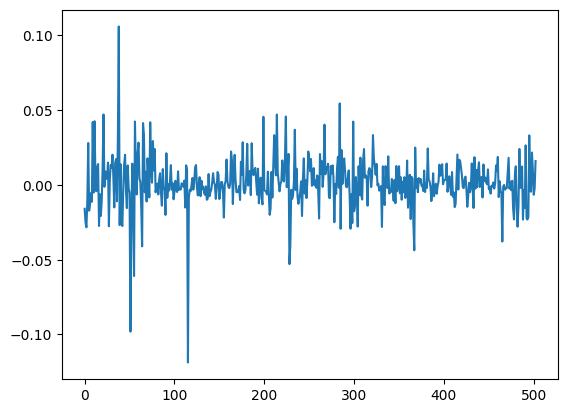

In [6]:
plt.plot(y)
# plt.plot(x)

In [7]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# DEVICE = "cpu"
print(f"Using {DEVICE} device")

Using mps device


In [120]:
class TimeSeriesDataSet(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return np.float32(self.x[idx]), np.float32(self.y[idx])

In [121]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [122]:
x_train.shape, y_train.shape

((402, 5), (402,))

In [123]:
x_test.shape, y_test.shape

((101, 5), (101,))

In [124]:
train_dataset = TimeSeriesDataSet(x_train, y_train)
test_dataset = TimeSeriesDataSet(x_test, y_test)

In [125]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [231]:
for d_x, d_y in test_dataloader:
    print(d_x.shape, d_y.shape, type(d_x))
    print(d_x, d_y)

torch.Size([101, 5]) torch.Size([101]) <class 'torch.Tensor'>
tensor([[ 7.3455e-03,  1.3798e-02,  4.2310e-04,  2.8900e-03,  3.3033e-03],
        [ 1.3798e-02,  4.2310e-04,  2.8900e-03,  3.3033e-03,  3.5727e-03],
        [ 4.2310e-04,  2.8900e-03,  3.3033e-03,  3.5727e-03,  1.4240e-02],
        [ 2.8900e-03,  3.3033e-03,  3.5727e-03,  1.4240e-02, -4.6111e-03],
        [ 3.3033e-03,  3.5727e-03,  1.4240e-02, -4.6111e-03,  9.6799e-04],
        [ 3.5727e-03,  1.4240e-02, -4.6111e-03,  9.6799e-04,  5.7332e-03],
        [ 1.4240e-02, -4.6111e-03,  9.6799e-04,  5.7332e-03, -1.5110e-03],
        [-4.6111e-03,  9.6799e-04,  5.7332e-03, -1.5110e-03, -6.6722e-03],
        [ 9.6799e-04,  5.7332e-03, -1.5110e-03, -6.6722e-03,  8.5867e-03],
        [ 5.7332e-03, -1.5110e-03, -6.6722e-03,  8.5867e-03, -7.9643e-03],
        [-1.5110e-03, -6.6722e-03,  8.5867e-03, -7.9643e-03, -5.0523e-03],
        [-6.6722e-03,  8.5867e-03, -7.9643e-03, -5.0523e-03, -1.4886e-02],
        [ 8.5867e-03, -7.9643e-03, -5.

In [322]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_layers = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_layers(x)
        return logits

model = NeuralNet().to(DEVICE)
print(model)
        

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [323]:
dataloaders = {}
dataset_sizes = {}

dataloaders['train']=train_dataloader
dataloaders['test'] = test_dataloader

dataset_sizes['train'] = len(train_dataloader)
dataset_sizes['test'] = len(test_dataloader)

In [324]:
lr = 1e-2

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [325]:
def train_model(model, steps, dataloaders, dataset_sizes, optimizer, criterion, schedulter):
    train_loss, test_loss = [], []

    for step in range(steps):
        print(f'\nSTEP: {step+1}', end='\t')
        
        for phase in ['train', 'test']:
            
            total_loss = 0
            
            if phase == 'train':
                model.train()
            elif phase == 'test':
                model.eval()
    
            for _x, _y in dataloaders[phase]:

                _y = _y.view(len(_y), -1)

                x_device, y_device = _x.to(DEVICE), _y.to(DEVICE)

                optimizer.zero_grad()
                prediction = model(x_device)
                loss = criterion(prediction, y_device)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                total_loss += loss

            if phase == 'train':
                train_loss.append((total_loss / dataset_sizes[phase]).detach().cpu().numpy())
                print(f'Train Loss: {total_loss / dataset_sizes[phase]:.5f},', end='\t')
            elif phase == 'test':
                test_loss.append((total_loss / dataset_sizes[phase]).detach().cpu().numpy())
                print(f'Train Loss: {total_loss / dataset_sizes[phase]:.5f}')

    return {'train losses': train_loss,
            'test losses': test_loss}

In [326]:
dataset_sizes

{'train': 1, 'test': 1}

In [327]:
history = train_model(model, 500, dataloaders, dataset_sizes, optimizer, loss_function, scheduler)


STEP: 1	Train Loss: 0.04755,	Train Loss: 0.03115

STEP: 2	Train Loss: 0.03085,	Train Loss: 0.02334

STEP: 3	Train Loss: 0.02310,	Train Loss: 0.01740

STEP: 4	Train Loss: 0.01722,	Train Loss: 0.01161

STEP: 5	Train Loss: 0.01149,	Train Loss: 0.00650

STEP: 6	Train Loss: 0.00645,	Train Loss: 0.00266

STEP: 7	Train Loss: 0.00269,	Train Loss: 0.00049

STEP: 8	Train Loss: 0.00061,	Train Loss: 0.00036

STEP: 9	Train Loss: 0.00057,	Train Loss: 0.00215

STEP: 10	Train Loss: 0.00244,	Train Loss: 0.00408

STEP: 11	Train Loss: 0.00443,	Train Loss: 0.00467

STEP: 12	Train Loss: 0.00504,	Train Loss: 0.00393

STEP: 13	Train Loss: 0.00428,	Train Loss: 0.00259

STEP: 14	Train Loss: 0.00289,	Train Loss: 0.00131

STEP: 15	Train Loss: 0.00157,	Train Loss: 0.00046

STEP: 16	Train Loss: 0.00068,	Train Loss: 0.00015

STEP: 17	Train Loss: 0.00033,	Train Loss: 0.00027

STEP: 18	Train Loss: 0.00041,	Train Loss: 0.00062

STEP: 19	Train Loss: 0.00073,	Train Loss: 0.00096

STEP: 20	Train Loss: 0.00105,	Train Los

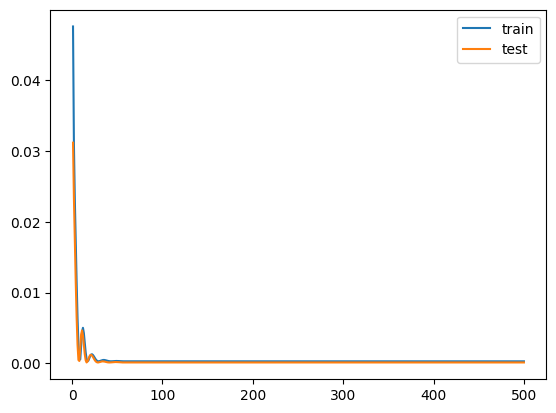

In [331]:
plt.plot([i + 1 for i in range(500)], history['train losses'], label='train')
plt.plot([i + 1 for i in range(500)], history['test losses'], label='test')

plt.legend()
plt.show()

---
LSTM

In [305]:
class LSTMTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, target_size, num_layers=1):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        torch.manual_seed(42)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers)

        # The linear layer that maps from hidden state space to tag space
        # simple lin regression
        torch.manual_seed(42)
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        

    def forward(self, time_series):
        lstm_out, _ = self.lstm(time_series)
        lstm_out = nn.ReLU()(lstm_out)
        tag_space = self.hidden2tag(lstm_out)
        return tag_space

In [306]:
def train_model(model, dataloaders, dataset_sizes, optimizer, criterion, num_epochs=20, treshold=1e-3, 
                print_stages=1, scheduler=None):

    train_loss = []
    val_loss = []
    l_rates = []
    epochs = []

    # best_model_wts = copy.deepcopy(model.state_dict())
    # best_loss = 1000.0

    for epoch in range(num_epochs):
        if epoch % print_stages == 0:
            if epoch:
                print('-' * 10)
            print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # phase = 'train'
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
    
            total_loss = 0
            total_metric = 0
            
            # loop over the training set
            for i, (x, y) in enumerate(dataloaders[phase]):
    
                y = y.view(len(y), -1)
    
                # send the input to the device
                (_x, _y) = (x.to(DEVICE), y.to(DEVICE))
                # print(x.shape, y.shape)
    
                # perform a forward pass and calculate the training loss
    
                with torch.set_grad_enabled(phase == 'train'):
                    prediction = model(_x)
                    
                    optimizer.zero_grad()
                    
                    loss = criterion(prediction, _y) # / len(prediction)
    
                    if phase == 'train':
                        loss.backward()
                        # torch.manual_seed(42)
                        optimizer.step()
                        
                # add the loss to the total training loss so far
                total_loss += loss
    
    
            if phase == 'train':
                train_loss.append((total_loss / dataset_sizes[phase]).cpu().detach().numpy())
                # l_rates.append(lr)
                # epochs.append(epoch)
                
            else:
                val_loss.append((total_loss / dataset_sizes[phase]).cpu().detach().numpy())
                # if best_loss < total_loss / dataset_sizes[phase]:
                #     best_loss = total_loss / dataset_sizes[phase]
                #     best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler is not None:
            scheduler.step()
        
        if epoch % print_stages == 0:
            print(f'Train loss: {train_loss[epoch]},\tVal loss: {val_loss[epoch]}')

        if scheduler is not None:
            scheduler.step()

    return {'train_loss': train_loss,
            'val_loss': val_loss,
            # 'best_model': best_model_wts,
            # 'learning_rates': l_rates,
            # 'epochs': epochs,
            'model': model}

In [307]:
ticker = 'LKOH'
lkoh_df = pd.DataFrame({'close': close_df[ticker] / close_df[ticker].shift() - 1,
                        # 'open': open_df[ticker] / open_df[ticker].shift() - 1,
                        # 'high': high_df[ticker] / high_df[ticker].shift() - 1,
                        # 'low': low_df[ticker] / low_df[ticker].shift() - 1,
                        # 'value':value_df[ticker] / value_df[ticker].shift() - 1,
                        # 'high/low':high_df[ticker] / low_df[ticker].shift() - 1
                       }).dropna()
# lkoh_df.columns = ["close"]

In [308]:
x, y = [], []
prev_dates, dates = [], []
window = 5

for sub_df in lkoh_df.rolling(window=6):
    if len(sub_df) < 6:
        continue
    # x.append(sub_df.values[:-1].flatten())
    # y.append(sub_df.values[-1][0])
    x.append(sub_df.close.values[:-1])
    y.append(sub_df.close.values[-1])
    prev_dates.append(sub_df.index[-2])
    dates.append(sub_df.index[-1])


x = np.array(x)
y = np.array(y)

In [309]:
x.shape, y.shape

((503, 5), (503,))

In [310]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [311]:
x_train.shape, y_train.shape

((402, 5), (402,))

In [312]:
x_test.shape, y_test.shape

((101, 5), (101,))

In [313]:
BATCH_SIZE = 32

train_dataset = TimeSeriesDataSet(x_train, y_train)
test_dataset = TimeSeriesDataSet(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=len(x_train), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(x_test), shuffle=False)

dataloaders = {}
dataset_sizes = {}

dataloaders['train']=train_dataloader
dataloaders['test'] = test_dataloader

dataset_sizes['train'] = len(train_dataloader)
dataset_sizes['test'] = len(test_dataloader)

In [314]:
lr = 1e-5

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (0.9, 0.9))
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

In [269]:
best_model = ...
best_loss = 1
best_params = {}

# TODO find best model
for hid_num in range(10, 500, 50):
    for num_lay in range(1, 10, 1):
        
        model = LSTMTagger(x_train.shape[-1], hid_num, 1, num_layers=num_lay).to(DEVICE)
        
        history = train_model(model, dataloaders, dataset_sizes, optimizer, criterion=loss_function, 
                                  num_epochs=3, treshold=1e-3, scheduler=scheduler)

        if history['val_loss'][-1] < best_loss:
            best_loss = history['val_loss'][-1]
            best_model = model
            best_params = {'hid_dim': hid_num,
                           'layers_num': num_lay}

Epoch 1/3
Train loss: 0.007554757408797741,	Val loss: 0.006993777584284544
----------
Epoch 2/3
Train loss: 0.007554757408797741,	Val loss: 0.006993777584284544
----------
Epoch 3/3
Train loss: 0.007554757408797741,	Val loss: 0.006993777584284544
Epoch 1/3
Train loss: 0.1589759886264801,	Val loss: 0.15741580724716187
----------
Epoch 2/3
Train loss: 0.1589759886264801,	Val loss: 0.15741580724716187
----------
Epoch 3/3
Train loss: 0.1589759886264801,	Val loss: 0.15741580724716187
Epoch 1/3
Train loss: 0.0741124227643013,	Val loss: 0.07477445900440216
----------
Epoch 2/3
Train loss: 0.0741124227643013,	Val loss: 0.07477445900440216
----------
Epoch 3/3
Train loss: 0.0741124227643013,	Val loss: 0.07477445900440216
Epoch 1/3
Train loss: 0.0007779186707921326,	Val loss: 0.0006690291338600218
----------
Epoch 2/3
Train loss: 0.0007779186707921326,	Val loss: 0.0006690291338600218
----------
Epoch 3/3
Train loss: 0.0007779186707921326,	Val loss: 0.0006690291338600218
Epoch 1/3
Train loss: 0.

In [270]:
best_params, best_loss

({'hid_dim': 310, 'layers_num': 5}, array(0.00014499, dtype=float32))

In [271]:
history.keys()

dict_keys(['train_loss', 'val_loss', 'model'])

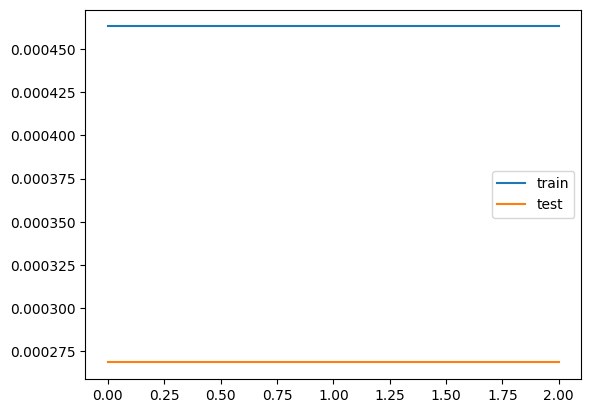

In [272]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='test')

plt.legend()
plt.show()

In [277]:
def run_model(model, dataloader, dataset_size, criterion):
    model.eval()
    total_loss = 0
    predicted_vec = []
    for _x, _y in dataloader:
        _y = _y.view(len(_y), -1)
        _x, _y = _x.to(DEVICE), _y.to(DEVICE)
        prediction = model(_x)
        total_loss += criterion(prediction, _y).detach().cpu().numpy()
        if len(predicted_vec):
            predicted_vec = np.concatenate((predicted_vec, prediction.detach().cpu().numpy().flatten()))
        else:
            predicted_vec = prediction.detach().cpu().numpy().flatten()
            
    return predicted_vec, total_loss / dataset_size
        

In [278]:
pred, loss = run_model(best_model, dataloaders['test'], dataset_sizes['test'], loss_function)

In [279]:
# pred, loss, y_test

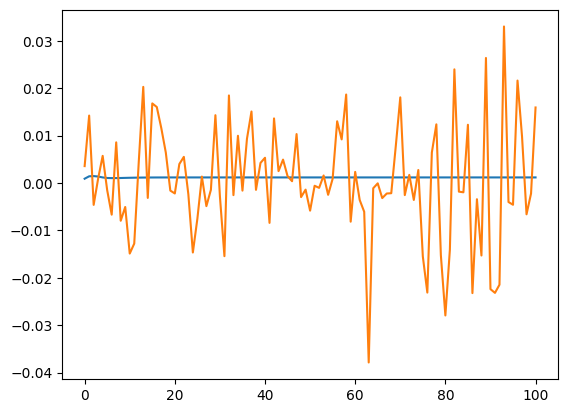

In [281]:
plt.plot(pred)
plt.plot(y_test)

In [290]:
def Sharp_Loss (pred, gt):
    
    sharp = (pred[:-1].flatten() * gt[1:].flatten()).mean() / gt[1:].flatten().std() * torch.sqrt(torch.tensor(gt[1:].flatten().size(dim=0)).to(DEVICE))
    # print(sharp.detach().cpu())
    return -sharp

In [292]:
best_params = {'hid_dim': 460, 'layers_num': 3}

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

model = LSTMTagger(x_train.shape[-1], best_params['hid_dim'], 1, num_layers=best_params['layers_num']).to(DEVICE)
        
history = train_model(model, dataloaders, dataset_sizes, optimizer, 
                      criterion=Sharp_Loss,   
                      # criterion=loss_function, 
                      num_epochs=60, treshold=1e-3, scheduler=scheduler, print_stages=10)

Epoch 1/60
Train loss: -0.017053186893463135,	Val loss: -0.003664932679384947
----------
Epoch 11/60
Train loss: -0.017053186893463135,	Val loss: -0.003664932679384947
----------
Epoch 21/60
Train loss: -0.017053186893463135,	Val loss: -0.003664932679384947
----------
Epoch 31/60
Train loss: -0.017053186893463135,	Val loss: -0.003664932679384947
----------
Epoch 41/60
Train loss: -0.017053186893463135,	Val loss: -0.003664932679384947
----------
Epoch 51/60
Train loss: -0.017053186893463135,	Val loss: -0.003664932679384947


In [257]:
pred, loss = run_model(model, dataloaders['test'], dataset_sizes['test'], loss_function)
loss

0.00024512619711458683

In [138]:
def min_max_scale(vec: np.ndarray) -> np.ndarray:
    return (vec - vec.min()) / (vec.max() - vec.min())

In [139]:
np.where(pred <= 0, 1, 0).sum(), np.where(y_test <= 0, 1, 0).sum()

(101, 55)

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_97918/1338997714.py:2: RuntimeWarning: divide by zero encountered in divide
  return (vec - vec.min()) / (vec.max() - vec.min())
/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_97918/1338997714.py:2: RuntimeWarning: invalid value encountered in divide
  return (vec - vec.min()) / (vec.max() - vec.min())


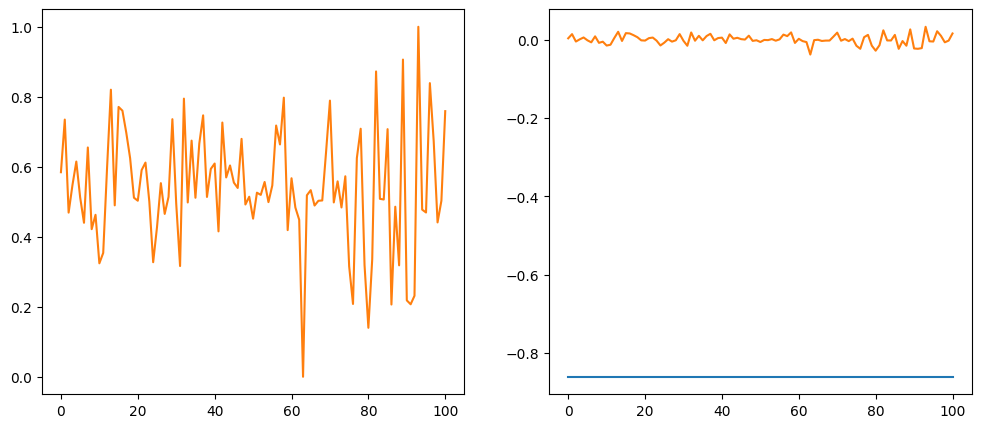

In [253]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5))

axs[0].plot(min_max_scale(pred), label='pred')
axs[0].plot(min_max_scale(y_test), label='gt')

axs[1].plot(pred, label='pred')
axs[1].plot(y_test, label='gt')

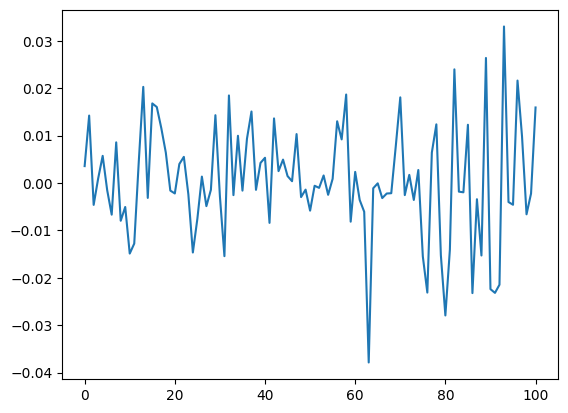

In [105]:
plt.plot(y_test)

---
Transformer

In [157]:
transformer_model = nn.Transformer(d_model = x_train.shape[-1], nhead = x_train.shape[-1])
output = transformer_model(torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_train, dtype=torch.float32))
output = nn.Linear(output.shape[-1], 1)(output)

/Users/hubievkasym/Desktop/Python Projects/SberProject/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [315]:
class Decepticon(nn.Module):
    def __init__(self,d_model, nhead, target_size):
        super(Decepticon, self).__init__()

        self.d_model = d_model
        self.nhead = nhead
        self.target_size = target_size

        torch.manual_seed(42)
        self.transformer = nn.Transformer(d_model = d_model, nhead = nhead)

        # The linear layer that maps from hidden state space to tag space
        # simple lin regression
        torch.manual_seed(42)
        self.output2tag = nn.Linear(d_model, target_size)
        

    def forward(self, time_series):
        output = self.transformer(time_series, time_series)
        # out = nn.ReLU()(lstm_out)
        tag_space = self.output2tag(output)
        return tag_space

In [316]:
model = Decepticon(x_train.shape[-1], x_train.shape[-1], 1).to(DEVICE)

/Users/hubievkasym/Desktop/Python Projects/SberProject/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [317]:
lr = 1e-1

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


history = train_model(model, dataloaders, dataset_sizes, optimizer, 
                      # criterion=Sharp_Loss,   
                      criterion=loss_function, 
                      num_epochs=600, treshold=1e-3, scheduler=scheduler, print_stages=10)

Epoch 1/600
Train loss: 0.7270339131355286,	Val loss: 0.4970150589942932
----------
Epoch 11/600
Train loss: 0.05684570595622063,	Val loss: 0.07197203487157822
----------
Epoch 21/600
Train loss: 0.009813644923269749,	Val loss: 0.013979408890008926
----------
Epoch 31/600
Train loss: 0.001172062591649592,	Val loss: 0.0015851190546527505
----------
Epoch 41/600
Train loss: 0.0008066990412771702,	Val loss: 0.00023204614990390837
----------
Epoch 51/600
Train loss: 0.0009563295752741396,	Val loss: 0.0008104198495857418
----------
Epoch 61/600
Train loss: 0.00041651425999589264,	Val loss: 0.00019189102749805897
----------
Epoch 71/600
Train loss: 0.000366677762940526,	Val loss: 0.00014504791761282831
----------
Epoch 81/600
Train loss: 0.0003551974950823933,	Val loss: 0.0001952409656951204
----------
Epoch 91/600
Train loss: 0.0003645680844783783,	Val loss: 0.00015680307114962488
----------
Epoch 101/600
Train loss: 0.0003267594729550183,	Val loss: 0.0001464540109736845
----------
Epoch 11

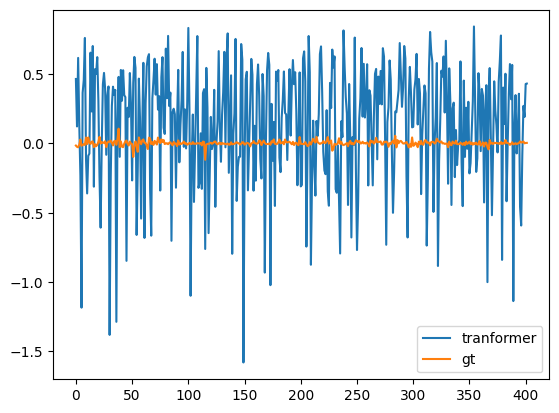

In [318]:
plt.plot(output.detach().numpy().flatten(), label='tranformer')
plt.plot(y_train, label='gt')

plt.legend()
plt.show()

In [319]:
pred, loss = run_model(model, dataloaders['test'], dataset_sizes['test'], loss_function)
loss

0.0001517751661594957

In [320]:
((pred - y_test)**2).sum() / len(pred)

0.0001517751606749715

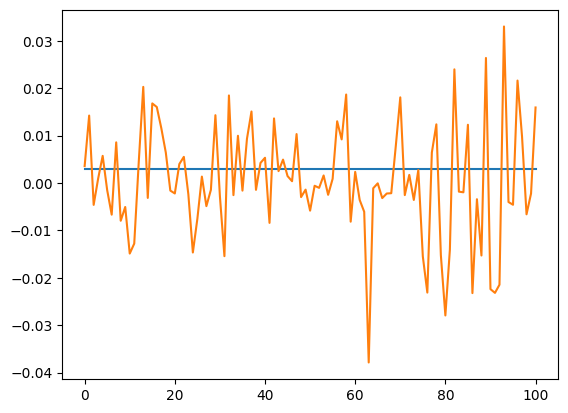

In [321]:
plt.plot(pred)
plt.plot(y_test)